<a href="https://colab.research.google.com/github/Hyun-hyo-min/mario_rl/blob/main/supermario_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535720 sha256=cb3efc45ce80662901f26b31b01c6ce28d3d9c0454a461f6d49f298901a284d0
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym은 강화학습을 위한 OpenAI 툴킷입니다.
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# OpenAI Gym을 위한 NES 에뮬레이터
from nes_py.wrappers import JoypadSpace

# OpenAI Gym에서의 슈퍼 마리오 환경 세팅
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

In [ ]:
# 슈퍼 마리오 환경 초기화하기 (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < "0.26":
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# 상태 공간을 2가지로 제한하기
#   0. 오른쪽으로 걷기
#   1. 오른쪽으로 점프하기
env = JoypadSpace(env, [["right"], ["left"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        # 모든 `skip` 프레임만 반환합니다.
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        # 행동을 반복하고 포상을 더합니다.
        total_reward = 0.0

        for i in range(self._skip):
            # 포상을 누적하고 동일한 작업을 반복합니다.
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward

            if done:
                break

        return obs, total_reward, done, trunk, info

In [ ]:
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # [H, W, C] 배열을 [C, H, W] 텐서로 변환
        observation = np.transpose(observation, [2, 0, 1])
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)
        return observation

In [ ]:
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)

        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        composed_transforms = transforms.Compose(
            [transforms.Resize(self.shape, antialias=True), transforms.Normalize(0, 255)]
        )
        observation = composed_transforms(observation).squeeze(0)
        return observation

In [ ]:
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)

if gym.__version__ < "0.26":
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        # 상태가 주어지면, 입실론-그리디 행동(epsilon-greedy action)을 선택해야 합니다.
        pass

    def cache(self, experience):
        # 메모리에 경험을 추가합니다.
        pass

    def recall(self):
        # 메모리로부터 경험을 샘플링합니다.
        pass

    def learn(self):
        # 일련의 경험들로 실시간 행동 가치(online action value) (Q) 함수를 업데이트 합니다.
        pass

In [ ]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # 마리오의 DNN은 최적의 행동을 예측합니다. - 추후 구현
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        # Mario Net 저장 사이의 경험 횟수
        self.save_every = 5e5

    def act(self, state):
        '''
        주어진 상태에서, epsilon-greedy 행동을 선택하고, 스텝의 값을 업데이트 합니다.

        입력값:
        state (``Lazy Frame``): 현재 상태에서의 단일 상태(observation)값을 말합니다. 차원은 (state_dim)입니다.

        출력값:
        ``action_idx`` (int): Mario가 수행할 행동을 나타내는 정수 값입니다.
        '''

        # 임의의 행동을 선택하기
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # 최적의 행동을 이용하기
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # exploration_rate 감소하기
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # 스텝 수 증가하기
        self.curr_step += 1

        return action_idx

In [ ]:
class Mario(Mario): # 연속성을 위한 하위 클래스
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        '''
        Store the experience to self.memory (replay buffer)

        입력값:
        state (``Lazy Frame``),
        next_state (``Lazy Frame``),
        action (``int``),
        reward (``float``),
        done(``bool``)
        '''
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x

        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)

        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({
            "state": state,
            "next_state": next_state,
            "action": action,
            "reward": reward,
            "done": done
            }, batch_size=[]))

    def recall(self):
        # 메모리에서 일련의 경험들을 검색합니다.
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))

        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [ ]:
class MarioNet(nn.Module):
    '''
    작은 CNN 구조
    입력 -> (conv2d + relu) * 3 -> flatten -> (dense + relu) * 2 -> 출력
    '''
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")

        if w != 84:
            raise ValueError(f"Expecting input height: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target 매개변수 값은 고정시킵니다.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)

        if model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

In [ ]:
# TD 추정 & TD 목표값

class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s, q)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [ ]:
# 모델 업데이트

class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

In [ ]:
# 체크포인트 저장

class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # 학습을 진행하기 전 최소한의 경험값
        self.learn_every = 3  # Q_online 업데이트 사이의 경험 횟수
        self.sync_every = 1e4  # Q_target과 Q_online sync 사이의 경험 수

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # 메모리로부터 샘플링을 합니다.
        state, next_state, action, reward, done = self.recall()

        # TD 추정값을 가져옵니다.
        td_est = self.td_estimate(state, action)

        # TD 목표값을 가져옵니다.
        td_tgt = self.td_target(reward, next_state, done)

        # 실시간 Q(Q_online)을 통해 역전파 손실을 계산합니다.
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

In [ ]:
# 기록하기

import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # 지표(Metric)와 관련된 리스트입니다.
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # 모든 record() 함수를 호출한 후 이동 평균(Moving average)을 계산합니다.
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # 현재 에피스드에 대한 지표를 기록합니다.
        self.init_episode()

        # 시간에 대한 기록입니다.
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "에피스드의 끝을 표시합니다."
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

Using CUDA: False

Episode 0 - Step 5 - Epsilon 0.9999987500006249 - Mean Reward 218.0 - Mean Length 5.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 2.381 - Time 2024-12-10T06:00:12
Episode 20 - Step 163 - Epsilon 0.9999592508251706 - Mean Reward 173.381 - Mean Length 7.762 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 30.694 - Time 2024-12-10T06:00:43
Episode 39 - Step 323 - Epsilon 0.9999192532500891 - Mean Reward 160.6 - Mean Length 8.075 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 31.162 - Time 2024-12-10T06:01:14


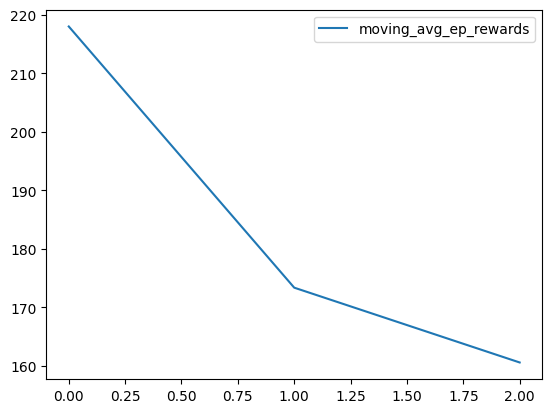

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 40
for e in range(episodes):

    state = env.reset()

    # 게임을 실행시켜봅시다!
    while True:

        # 현재 상태에서 에이전트 실행하기
        action = mario.act(state)

        # 에이전트가 액션 수행하기
        next_state, reward, done, trunc, info = env.step(action)

        # 기억하기
        mario.cache(state, next_state, action, reward, done)

        # 배우기
        q, loss = mario.learn()

        # 기록하기
        logger.log_step(reward, loss, q)

        # 상태 업데이트하기
        state = next_state

        # 게임이 끝났는지 확인하기
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)